In [1]:

# Imports 
import numpy as np
import matplotlib.pyplot as plt 
from astropy import units as u   
import pandas as pd
import scipy
import scipy.constants as cst
import artpop
from scipy.signal import savgol_filter


# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# pd output style
pd.set_option('display.float_format','{:.6e}'.format)

In [2]:
# read in data
file_path = "HD37962.txt"

df = pd.read_csv(file_path, sep=" ", skiprows=1, names = ("wavelength","flux_density"))
print(df.head(10))

    wavelength  flux_density
0 2.500462e+03  1.114300e-13
1 2.501836e+03  9.876600e-14
2 2.503209e+03  1.032900e-13
3 2.504583e+03  1.057000e-13
4 2.505956e+03  8.753900e-14
5 2.507330e+03  8.557200e-14
6 2.508703e+03  9.689000e-14
7 2.510077e+03  9.514300e-14
8 2.511450e+03  8.783000e-14
9 2.512824e+03  8.204600e-14


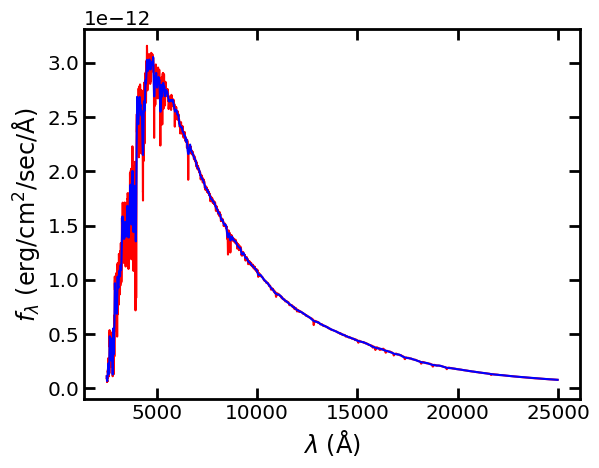

In [3]:
# Plot flux vs wavelength and smoothed version
plt.plot(df["wavelength"], df["flux_density"], c='r', mec='k')
yhat = savgol_filter(df["flux_density"], 51, 5)
plt.plot(df["wavelength"], yhat, c='blue', mec='k')
# plt.legend()
# plt.minorticks_on()
plt.xlabel(r'$\lambda$ (Å)')
plt.ylabel(r'$f_\lambda$ (erg/cm${}^2$/sec/Å) ');

In [4]:
# Planck Function in SI, with scale to compensate steradians and distance
def planck_func(wavelength, temp, scale):
    lam = wavelength*1e-10
    b = 2*cst.h*cst.c*cst.c/((lam**5)*np.expm1(cst.h*cst.c/lam/cst.k/temp))
    return b*1e-7*scale

In [5]:
# Fit function on data, get tenperature and scale
popt, pcov = scipy.optimize.curve_fit(planck_func, df["wavelength"], df["flux_density"], p0=(5800,1e-18), method="lm")
print(popt)

[5.50404553e+03 1.25735465e-18]


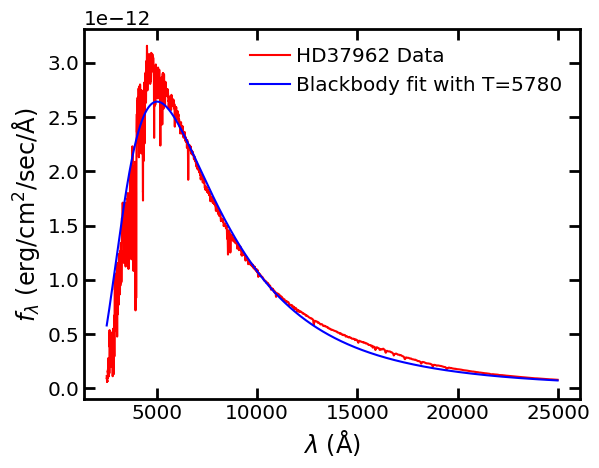

In [6]:
# Plot data and fit
df["exp_flux_density"] = planck_func(df["wavelength"], 5780, 1e-18)
plt.plot(df["wavelength"], df["flux_density"], c='r', mec='k', label = 'HD37962 Data')
plt.plot(df["wavelength"], df["exp_flux_density"], c='blue', mec='k',label = 'Blackbody fit with T=5780')
plt.legend()
plt.xlabel(r'$\lambda$ (Å)')
plt.ylabel(r'$f_\lambda$ (erg/cm${}^2$/sec/Å) ');

In [26]:
# Calculate the average flux using sample responses
b_file_path = "B.txt"
v_file_path = "V.txt"
B_band = pd.read_csv(b_file_path, sep=" ", skiprows=1, names = ("wavelength","response"))
V_band = pd.read_csv(v_file_path, sep=" ", skiprows=1, names = ("wavelength","response"))

df['b_response'] = np.interp(df['wavelength'], B_band['wavelength'], B_band['response'], left = 0.0, right = 0.0)
df['v_response'] = np.interp(df['wavelength'], V_band['wavelength'], V_band['response'], left = 0.0, right = 0.0)

df['b_flux'] = np.multiply(df['b_response'], df['flux_density'])
df['v_flux'] = np.multiply(df['v_response'], df['flux_density'])

B_avg_flux = scipy.integrate.simpson(df['b_flux'], x=df['wavelength']) / (B_band.iloc[-1,0] - B_band.iloc[1,0])
V_avg_flux = scipy.integrate.simpson(df['v_flux'], x=df['wavelength']) / (V_band.iloc[-1,0] - V_band.iloc[1,0])
print(B_avg_flux)
print(V_avg_flux)


1.3071214834211314e-12
1.0872243690085557e-12


: 

Now, we finish the PSet by writing the numnerical ODE solver:

In [1647]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [1648]:
# Function for solving Lane–Emden ODE, phi is -\xi_1^2(d\theta/d\xi)_{\xi_1}
def le(t, state, n):
    theta, phi = state
    
    dtheta = -phi/np.power(t,2)
    dphi = np.multiply((np.power(theta,n)),np.power(t,2))
    
    return [dtheta, dphi]

In [1649]:
y0 = [0.9999999, 0.0]  # Initial state of the system
t_span = (0.000000000001, 10.2) # span of xi
t_eval = np.linspace(0.000000000001, 10.2, 1020000)

In [1650]:
# run ODE solvers, have special cases to have custom span range
ode_results = []

for i in range(13):
    if i == 0:
        ode_results.append(solve_ivp(le, (0.000000000001, 2.46), y0, args=(i*0.5,), t_eval = np.linspace(0.000000000001, 2.46, 246000), method = 'DOP853')) 
        continue
    if i == 2:
        ode_results.append(solve_ivp(le, (0.000000000001, 3.18), y0, args=(i*0.5,), t_eval = np.linspace(0.000000000001, 3.18, 318000), method = 'DOP853')) 
        continue
    if i == 4:
        ode_results.append(solve_ivp(le, (0.000000000001, 4.4), y0, args=(i*0.5,), t_eval = np.linspace(0.000000000001, 4.4, 440000), method = 'DOP853')) 
        continue
    if i == 6:
        ode_results.append(solve_ivp(le, (0.000000000001, 7), y0, args=(i*0.5,), t_eval = np.linspace(0.000000000001, 7, 700000), method = 'DOP853')) 
        continue
    ode_results.append(solve_ivp(le, t_span, y0, args=(i*0.5,), t_eval = t_eval, method = 'DOP853')) 

C:\Users\Dennis Wu\AppData\Local\Temp\ipykernel_45448\4056863920.py:6: RuntimeWarning: invalid value encountered in power
  dphi = np.multiply((np.power(theta,n)),np.power(t,2))


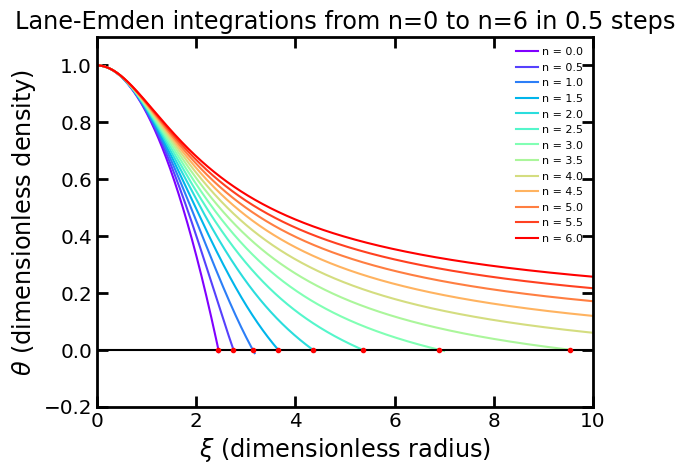

In [1651]:
# Plot results from ODE solver
from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, 13))

for i in range(13):
    plt.plot(ode_results[i].t, ode_results[i].y[0, :], c=color[i], label = 'n = ' +str(i/2.0))
plt.title("Lane-Emden integrations from n=0 to n=6 in 0.5 steps")
plt.legend(prop={'size': 8})
plt.ylim(-0.2,1.1)
plt.xlim(0,10)
plt.xlabel(r'$\xi$ (dimensionless radius)')
plt.ylabel(r'$\theta$ (dimensionless density)')
plt.axhline(y=0.0, color='black', linestyle='-')

# find zeros for the functions 
idx = []
for i in range(13):
    temp = np.argwhere(np.diff(np.sign(ode_results[i].y[0, :]-0.000005))).flatten()
    idx.append((ode_results[i].t[temp], ode_results[i].y[0, :][temp], ode_results[i].y[1, :][temp]))
    plt.plot(ode_results[i].t[temp], ode_results[i].y[0, :][temp], 'r.')

In [1652]:
# Calculate the parameters for each polytrope
pd.set_option('display.float_format','{:.6e}'.format)
soln = pd.DataFrame(idx[0:8], columns = ("xi_1", "theta","phi"))
soln['xi_1'] = soln['xi_1'].str[0]
soln['theta'] = soln['theta'].str[0]
soln['phi'] = soln['phi'].str[0]
soln.drop(columns = 'theta')
soln.drop(0, inplace= True)
soln.insert(0, column = 'n', value = np.arange(0.5,4,0.5))
soln['D'] = (soln['xi_1'].pow(3))/(soln['phi'])/3
soln['Pc'] = (soln['xi_1'].pow(4))/(soln['phi'].pow(2))/(4*cst.pi)/(np.arange(1,8,1))
soln


,n,xi_1,theta,phi,D,Pc
1,5.000000e-01,2.752683e+00,6.718065e-06,3.788605e+00,1.835134e+00,3.183143e-01
2,1.000000e+00,3.141570e+00,7.380904e-06,3.141566e+00,3.289825e+00,3.926944e-01
3,1.500000e+00,3.653744e+00,5.096516e-06,2.714108e+00,5.990538e+00,6.417516e-01
4,2.000000e+00,4.352840e+00,5.723320e-06,2.411038e+00,1.140231e+01,1.228607e+00
5,2.500000e+00,5.355215e+00,5.620707e-06,2.187200e+00,2.340567e+01,2.736220e+00
6,3.000000e+00,6.896750e+00,5.149604e-06,2.018236e+00,5.418016e+01,7.366701e+00
7,3.500000e+00,9.535599e+00,5.184391e-06,1.890557e+00,1.528738e+02,2.629690e+01


c:\ProgramData\Anaconda3\envs\phy555\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\phy555\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


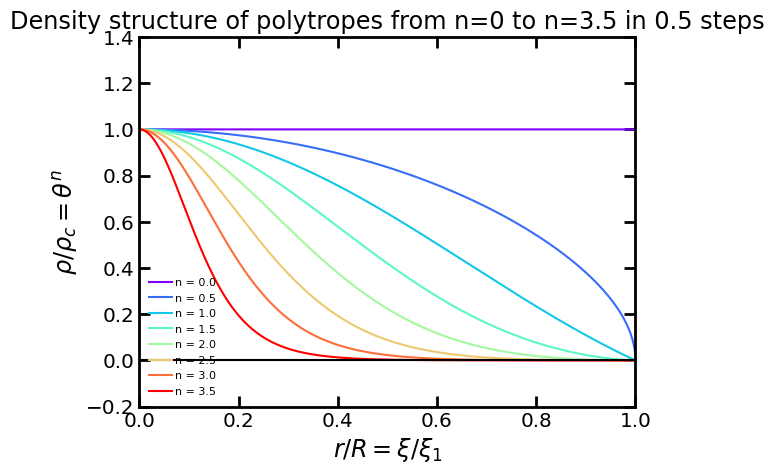

In [1653]:
# plot the density structure

color = cm.rainbow(np.linspace(0, 1, 8))

soln = pd.DataFrame(idx[0:8], columns = ("xi_1", "theta","phi"))
for i in range(8):
    plt.plot(ode_results[i].t/soln['xi_1'][i], np.power(ode_results[i].y[0, :],i*0.5), c=color[i], label = 'n = ' +str(i/2.0))
plt.title("Density structure of polytropes from n=0 to n=3.5 in 0.5 steps")
plt.legend(prop={'size': 8})
plt.ylim(-0.2,1.4)
plt.xlim(0,1)
plt.xlabel(r'$r/R = \xi/\xi_1$')
plt.ylabel(r'$\rho/\rho_c = \theta^n$')
plt.axhline(y=0.0, color='black', linestyle='-')

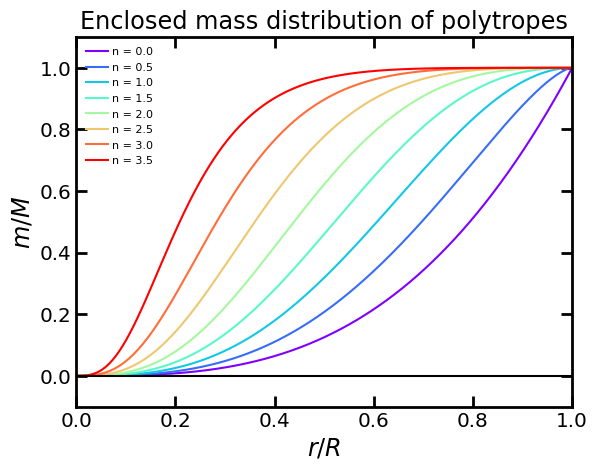

In [1654]:
# Integrate enclosed mass
import scipy.integrate as integrate

soln = pd.DataFrame(idx[0:8], columns = ("xi_1", "theta","phi"))
soln.drop(columns = 'theta', inplace=True)
soln.insert(0, column = 'n', value = np.arange(0,4,0.5))
soln['D'] = (soln['xi_1'].pow(3))/(soln['phi'])/3
soln['Pc'] = (soln['xi_1'].pow(4))/(soln['phi'].pow(2))/(4*cst.pi)/(np.arange(0,8,1))
# print(soln)

int_result = []
for i in range(8):
    dx = (ode_results[i].t[1]-ode_results[i].t[0])/soln['xi_1'][i]
    integrand = np.multiply(np.power(ode_results[i].y[0, :],i*0.5), np.power((ode_results[i].t/soln['xi_1'][i]), 2))*soln['D'][i]*3 #4*pi*r^2*rho dr / (4*pi*R^3*avg_rho/3)
    int_result.append(integrate.cumulative_trapezoid(integrand, x=(ode_results[i].t/soln['xi_1'][i]), dx=dx, initial=0))

# Function for integrating enclosed mass


for i in range(8):
    plt.plot(ode_results[i].t/soln['xi_1'][i], int_result[i], c=color[i], label = 'n = ' +str(i/2.0))
# plt.plot(ode_results[i].t/soln['xi_1'][i], np.power((ode_results[i].t/soln['xi_1'][i]),3))
plt.title("Enclosed mass distribution of polytropes")
plt.legend(prop={'size': 8})
plt.ylim(-0.1,1.1)
plt.xlim(0,1)
plt.xlabel(r'$r/R$')
plt.ylabel(r'$m/M$')
plt.axhline(y=0.0, color='black', linestyle='-')



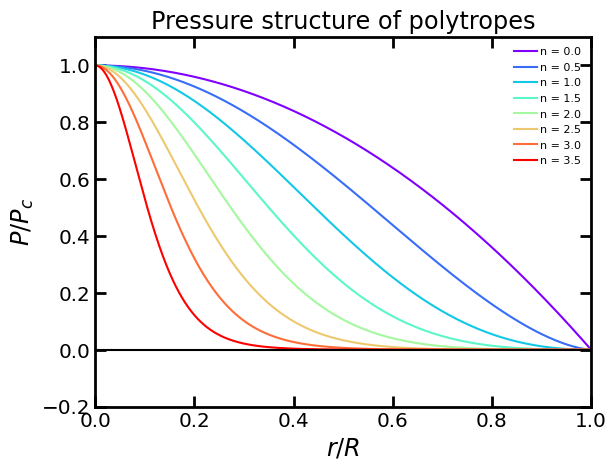

In [1655]:
# Use derived relation to plot pressure structures
for i in range(8):
    plt.plot(ode_results[i].t/soln['xi_1'][i], np.power(ode_results[i].y[0, :],(i*0.5+1)), c=color[i], label = 'n = ' +str(i/2.0))
plt.title("Pressure structure of polytropes")
plt.legend(prop={'size': 8})
plt.ylim(-0.2,1.1)
plt.xlim(0,1)
plt.xlabel(r'$r/R$')
plt.ylabel(r'$P/P_c$')
plt.axhline(y=0.0, color='black', linestyle='-')

C:\Users\Dennis Wu\AppData\Local\Temp\ipykernel_45448\346554433.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot((ode_results[4].t/soln['xi_1'][4]), (numer/denom), c='red')


Text(0, 0.5, '$(dP/dr)/(\\rho m/r^2) \\times$ const')

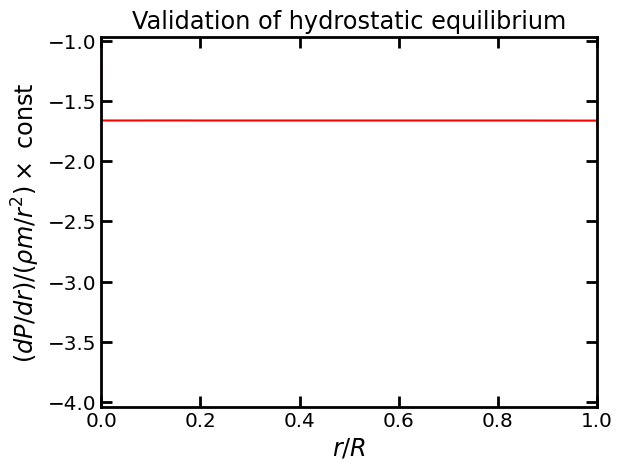

In [1656]:
# Validate hydrostatic equilibrium
numer = np.gradient(np.power(ode_results[4].y[0, :],3),ode_results[4].t/soln['xi_1'][4])
denom = np.multiply(np.power(ode_results[4].y[0, :],2), int_result[4])/np.power((ode_results[4].t/soln['xi_1'][4]), 2)
plt.plot((ode_results[4].t/soln['xi_1'][4]), (numer/denom), c='red')
plt.title("Validation of hydrostatic equilibrium")
plt.xlim(0,1)
plt.xlabel(r'$r/R$')
plt.ylabel(r'$(dP/dr)/(\rho m/r^2) \times$ const')